# Proyek Klasifikasi Gambar: [**fruit quality 3 classes**]
- **Nama:** M Mahfudl Awaludin
- **Email:** mahfudawaludin.009@gmail.com

Dataset "Fruit Quality - 3 Classes" yang dibuat oleh Pavish Karthik berisi gambar buah dengan tiga kategori kualitas, yaitu:

1. Fresh – Buah segar tanpa tanda-tanda pembusukan.
2. Moderately Rotten – Buah yang mulai membusuk dengan beberapa bagian rusak.
3. Completely Rotten – Buah yang sudah membusuk sepenuhnya.

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [ ]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mmahfudlawaludin","key":"3262655cdc1ea41cd720968fbe327b95"}'}

In [ ]:
import os
import zipfile

# Buat folder .kaggle dan pindahkan kaggle.json ke sana
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Beri izin akses ke file

# Unduh dataset dari Kaggle
!kaggle datasets download pavishkarthik/fruit-quality-3-classes




Dataset URL: https://www.kaggle.com/datasets/pavishkarthik/fruit-quality-3-classes
License(s): unknown


In [ ]:
# Ekstrak file zip
with zipfile.ZipFile("/content/fruit-quality-3-classes.zip", "r") as zip_ref:
    zip_ref.extractall("fruit-quality")

# Cek isi folder
os.listdir("fruit-quality")

['Completely rotten', 'Fresh', 'Moderately rotten']

### Data Preprocessing

### Dataset Checking

**Cek Resolusi Gambar dalam Dataset**

In [ ]:
import cv2
from collections import Counter

# Path ke folder dataset
dataset_path = "/content/fruit-quality"

# Dictionary untuk menyimpan resolusi gambar
resolutions = []

# Loop melalui setiap kategori dalam dataset
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):  # Pastikan itu folder
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)  # Baca gambar
            if img is not None:
                resolutions.append(img.shape[:2])  # Simpan (tinggi, lebar)

# Hitung jumlah gambar dengan setiap resolusi unik
resolution_counts = Counter(resolutions)

# Cetak hasil
for res, count in resolution_counts.items():
    print(f"Resolusi: {res}, Jumlah Gambar: {count}")

# Cek apakah semua gambar memiliki resolusi seragam atau tidak
if len(resolution_counts) > 1:
    print("\nGambar dalam dataset memiliki resolusi yang TIDAK seragam.")
else:
    print("\nGambar dalam dataset memiliki resolusi yang SERAGAM.")


Resolusi: (256, 192), Jumlah Gambar: 4536
Resolusi: (256, 256), Jumlah Gambar: 11926
Resolusi: (192, 256), Jumlah Gambar: 1897
Resolusi: (256, 144), Jumlah Gambar: 12
Resolusi: (144, 256), Jumlah Gambar: 9
Resolusi: (4000, 3000), Jumlah Gambar: 381
Resolusi: (6000, 8000), Jumlah Gambar: 183

Gambar dalam dataset memiliki resolusi yang TIDAK seragam.


**Menampilkan Contoh Gambar dari Dataset**

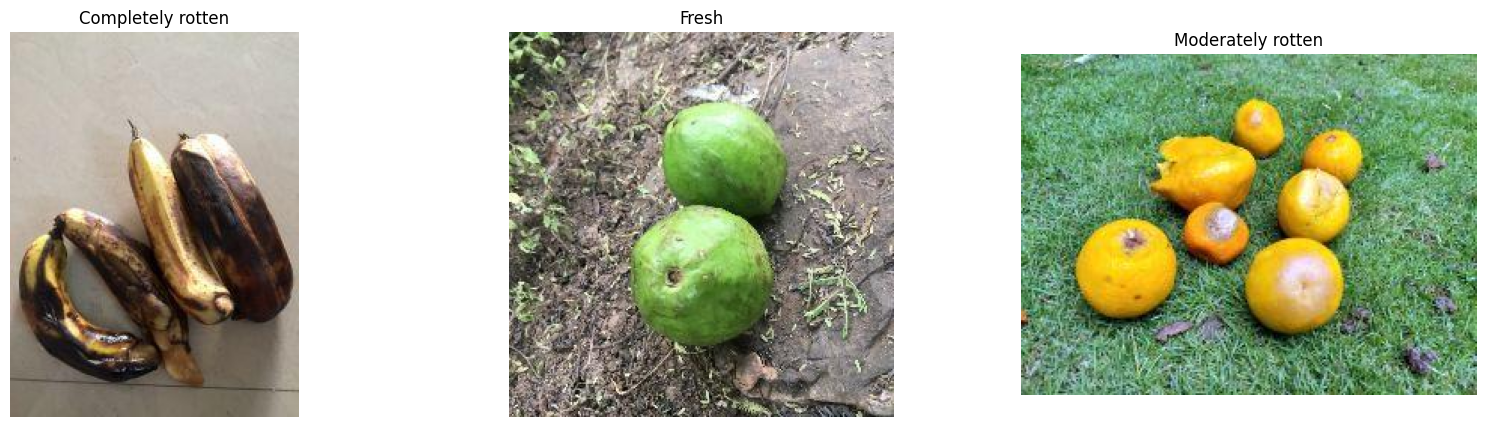

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Path ke folder dataset
dataset_path = "/content/fruit-quality"

# Ambil daftar kategori (kelas)
categories = sorted(os.listdir(dataset_path))

# Buat plot untuk menampilkan gambar dari setiap kelas
fig, axes = plt.subplots(1, len(categories), figsize=(20, 5))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)

    # Ambil satu gambar dari folder kategori
    image_files = os.listdir(category_path)
    if len(image_files) > 0:
        img_path = os.path.join(category_path, image_files[0])  # Ambil gambar pertama
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB

        # Tampilkan gambar
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(category)

plt.show()


**Menghitung Total Gambar dalam Dataset**

In [ ]:
import os

# Path ke folder dataset
dataset_path = "/content/fruit-quality"

# Hitung jumlah total gambar
total_images = 0
class_counts = {}

# Loop melalui setiap kategori dalam dataset
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):  # Pastikan itu folder
        num_images = len(os.listdir(category_path))  # Hitung jumlah gambar dalam folder
        class_counts[category] = num_images
        total_images += num_images

# Cetak hasil
print("Jumlah gambar per kelas:")
for category, count in class_counts.items():
    print(f"{category}: {count} gambar")

print(f"\nTotal jumlah gambar dalam dataset: {total_images}")


Jumlah gambar per kelas:
Completely rotten: 6788 gambar
Fresh: 11082 gambar
Moderately rotten: 1074 gambar

Total jumlah gambar dalam dataset: 18944


In [ ]:
import os
import shutil

train_dir = "fruit-quality"  # Ubah path jika diperlukan
test_dir = "fruit-quality"  # Ubah path jika diperlukan

# Direktori baru untuk dataset gabungan
combined_dir = "fruit/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

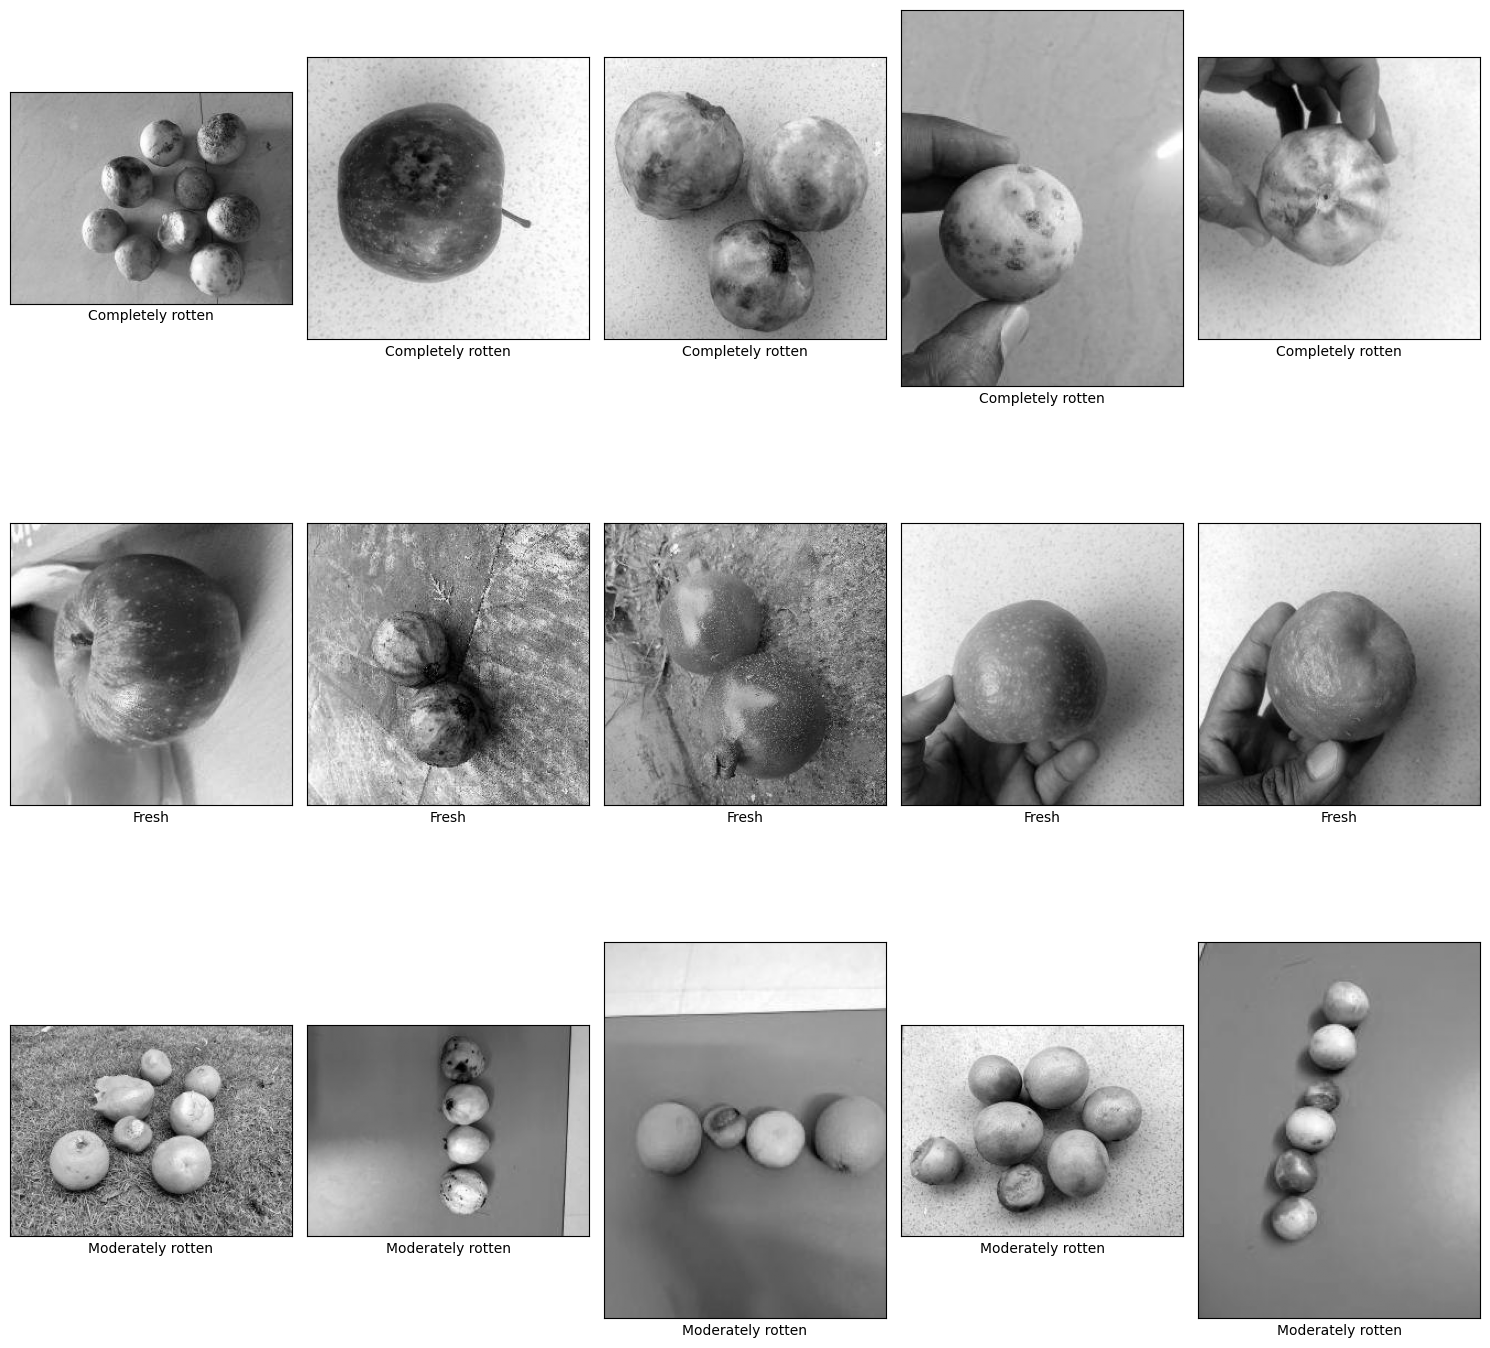

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
# path = "chest_xray/" # path yang salah
path = "fruit/dataset" # path yang benar, sesuaikan dengan path dataset Anda
path_sub = os.path.join(path) # Direktori dataset utama
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
# path_sub = "chest_xray/dataset/"  # path yang salah
path_sub = "fruit/dataset" # path yang benar, sesuaikan dengan path dataset Anda

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot Distribusi**

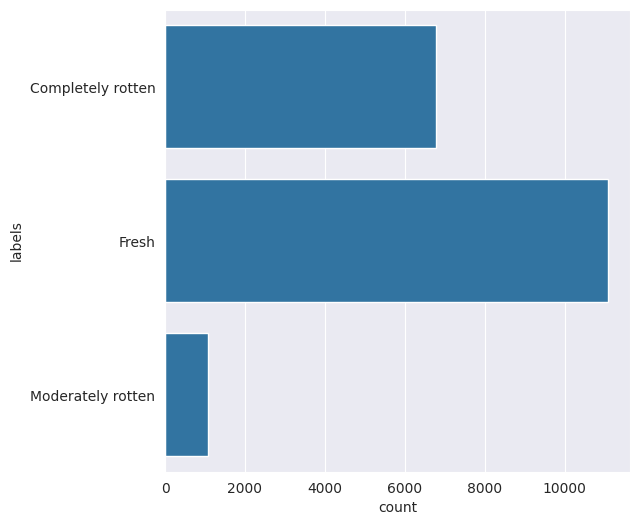

In [ ]:
# Definisikan path sumber
lung_path = "fruit/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Import seaborn
import seaborn as sns # This line imports the seaborn library and assigns it to the alias 'sns'
import matplotlib.pyplot as plt
# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

**Data Augmentation**

In [ ]:

# Path dataset
dataset_path = "/content/fruit/dataset"
augmented_path = dataset_path  # Simpan di folder yang sama

# Fungsi Augmentasi
def anticlockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    angle = random.randint(0, 180)
    return rotate(img, angle)

def clockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    angle = random.randint(0, 180)
    return rotate(img, -angle)

def flip_up_down(img):
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.resize(img, (224, 224))
    return adjust_gamma(img, gamma=0.5, gain=1)

def blur_image(img):
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    return warp(img, transform, mode="wrap")

def warp_shift(img):
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    return warp(img, transform, mode="wrap")

# Daftar transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Kelas yang membutuhkan augmentasi
augmentation_targets = {
    'Completely rotten': 4294,
    'Moderately rotten': 10008
}

# Loop melalui setiap kategori yang membutuhkan augmentasi
for category, images_to_generate in augmentation_targets.items():
    category_path = os.path.join(dataset_path, category)
    augmented_category_path = os.path.join(augmented_path, category)

    if not os.path.exists(augmented_category_path):
        os.makedirs(augmented_category_path)

    images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith('.jpg')]
    i = 1

    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)
            transformed_image = original_image
            transformation_count = random.randint(1, len(transformations))

            for _ in range(transformation_count):
                key = random.choice(list(transformations.keys()))
                transformed_image = transformations[key](transformed_image)

            new_image_path = os.path.join(augmented_category_path, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1
        except ValueError as e:
            print(f"Could not read {image}: {e}. Skipping.")

print("Augmentation completed successfully!")


Augmentation completed successfully!


### Data Splitting

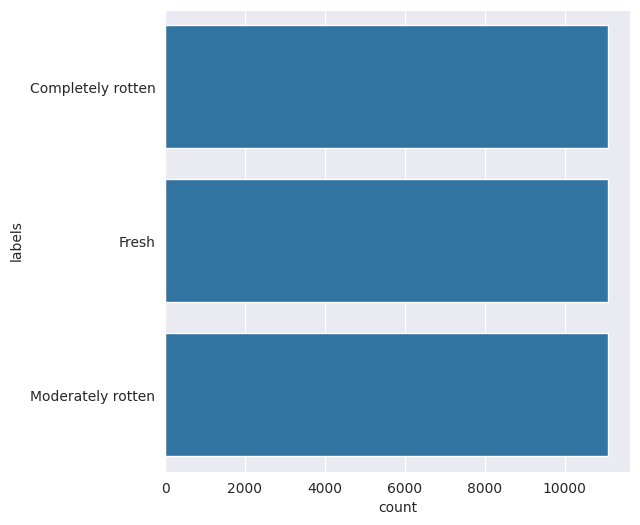

In [ ]:
# Definisikan path sumber
lung_path = "fruit/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'fruit/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Completely rotten,11082
Fresh,11082
Moderately rotten,11082


In [ ]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset menjadi train (70%), test (15%), dan validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=300)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=300)

In [ ]:
# Membuat DataFrame untuk tiap set
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})  # Validation Set


In [ ]:
# Gabungkan semua DataFrame
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

# Cek distribusi data
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Path dataset sumber dan tujuan
datasource_path = "fruit/dataset/"
dataset_path = "Dataset-Final/"



set    labels           
test   Completely rotten    1641
       Fresh                1683
       Moderately rotten    1663
train  Completely rotten    7776
       Fresh                7764
       Moderately rotten    7732
val    Completely rotten    1665
       Fresh                1635
       Moderately rotten    1687
dtype: int64 


                                                    path             labels  \
15607       fruit/dataset/Completely rotten/IMG_7604.JPG  Completely rotten   
29268       fruit/dataset/Completely rotten/IMG_7320.JPG  Completely rotten   
22211  fruit/dataset/Moderately rotten/augmented_imag...  Moderately rotten   
11082  fruit/dataset/Completely rotten/IMG20200728182...  Completely rotten   
24104  fruit/dataset/Moderately rotten/augmented_imag...  Moderately rotten   

         set  
15607  train  
29268    val  
22211  train  
11082  train  
24104   test  


In [ ]:
from tqdm import tqdm
# Memindahkan file ke direktori yang sesuai
for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']

    # Jika file tidak ditemukan, coba cari ulang di folder sesuai label
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], os.path.basename(file_path))

    # Buat direktori tujuan
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)  # Hindari error jika folder sudah ada

    # Tentukan path tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file hanya jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

100%|██████████| 33246/33246 [00:16<00:00, 2066.65it/s]


## Modelling

### Image Data Generator

In [ ]:
import os

# Definisikan direktori untuk training, validation, dan test
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/val/"
TEST_DIR = "Dataset-Final/test/"

# Definisikan kategori label dalam dataset
labels = ["Moderately rotten", "Completely rotten", "Fresh"]

# Fungsi untuk menghitung jumlah gambar dalam setiap kategori
def count_images(directory, label):
    path = os.path.join(directory, label)
    return len(os.listdir(path)) if os.path.exists(path) else 0

# Menampilkan jumlah gambar dalam setiap kategori untuk train, val, dan test set
print("=" * 50)
print(f"{'Kategori':<20} {'Train':<10} {'Validation':<12} {'Test':<10}")
print("=" * 50)

for label in labels:
    train_count = count_images(TRAIN_DIR, label)
    val_count = count_images(VAL_DIR, label)
    test_count = count_images(TEST_DIR, label)

    print(f"{label:<20} {train_count:<10} {val_count:<12} {test_count:<10}")

print("=" * 50)


Kategori             Train      Validation   Test      
Moderately rotten    7732       1687         1663      
Completely rotten    7776       1665         1641      
Fresh                7764       1635         1683      


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi hanya untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Geser horizontal
    height_shift_range=0.2, # Geser vertikal
    shear_range=0.2,        # Distorsi geser
    zoom_range=0.2,         # Zooming acak
    horizontal_flip=True,   # Membalik gambar horizontal
    fill_mode='nearest'     # Mengisi area kosong akibat augmentasi
)

# Normalisasi tanpa augmentasi untuk validation & test set
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',  # Karena ada banyak kelas
    shuffle=True               # Harus di-shuffle untuk melatih model dengan baik
)

# Validation data generator
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',  # Karena ada banyak kelas
    shuffle=False              # Tidak perlu di-shuffle
)

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',  # Karena ada banyak kelas
    shuffle=False              # Tidak perlu di-shuffle agar evaluasi konsisten
)

# Cek jumlah kelas yang terdeteksi
print("Detected classes:", train_generator.class_indices)


Found 23272 images belonging to 3 classes.
Found 4987 images belonging to 3 classes.
Found 4987 images belonging to 3 classes.
Detected classes: {'Completely rotten': 0, 'Fresh': 1, 'Moderately rotten': 2}


### Pembangunan Model dengan Beberapa Skema Parameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Pastikan sesi sebelumnya dibersihkan
tf.keras.backend.clear_session()

# Inisialisasi model Sequential
model = Sequential()

# Layer 1: Conv2D + BatchNormalization + MaxPooling
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Layer 2: Conv2D + BatchNormalization + MaxPooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Layer 3: Conv2D + BatchNormalization + MaxPooling
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Layer 4: Conv2D + BatchNormalization + MaxPooling (Tambahan untuk meningkatkan akurasi)
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Flatten layer untuk meratakan output menjadi vektor
model.add(Flatten())

# Fully Connected Layer (Dense)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output Layer dengan Softmax untuk Multi-Class Classification
num_classes = 3  # Menyesuaikan dengan jumlah kelas dataset
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,732,291 (21.87 MB)

 Trainable params: 5,731,331 (21.86 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ambil jumlah gambar dalam setiap kelas langsung dari train_generator
class_indices = train_generator.class_indices  # Dictionary {label_name: index}
num_classes = len(class_indices)  # Jumlah kelas
labels = list(class_indices.values())  # Daftar label (0,1,2,...)

# Ambil label setiap gambar dari train_generator
train_labels = train_generator.classes  # Label dari semua gambar dalam training set

# Menghitung class weights berdasarkan jumlah sampel yang ada
class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.array(labels),
    y=train_labels
)

# Konversi ke dictionary {0: weight_0, 1: weight_1, ..., n: weight_n}
class_weights = {i: class_weights_values[i] for i in range(num_classes)}

# Tampilkan class weights
print("Class weights:", class_weights)

# Callback 1: EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Callback 2: ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Callback 3: ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# List callback
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Training model dengan class weights dan callbacks
history_1 = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights,  # Menyertakan class weights saat pelatihan
    callbacks=callbacks          # Menambahkan callback
)


Class weights: {0: np.float64(0.997599451303155), 1: np.float64(0.9991413360810579), 2: np.float64(1.0032764269701673)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7160 - loss: 0.7800
Epoch 1: val_loss improved from inf to 0.29254, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 234s 307ms/step - accuracy: 0.7161 - loss: 0.7797 - val_accuracy: 0.8955 - val_loss: 0.2925 - learning_rate: 1.0000e-04
Epoch 2/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8491 - loss: 0.4046
Epoch 2: val_loss improved from 0.29254 to 0.26316, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 211s 289ms/step - accuracy: 0.8492 - loss: 0.4046 - val_accuracy: 0.8977 - val_loss: 0.2632 - learning_rate: 1.0000e-04
Epoch 3/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8764 - loss: 0.3495
Epoch 3: val_loss did not improve from 0.26316
728/728 ━━━━━━━━━━━━━━━━━━━━ 211s 289ms/step - accuracy: 0.8764 - loss: 0.3495 - val_accuracy: 0.8572 - val_loss: 0.3402 - learning_rate: 1.0000e-04
Epoch 4/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8870 - loss: 0.3186
Epoch 4: val_loss did not improve from 0.26316
728/728 ━━━━━━━━━━━━━━━━━━━━ 213s 293ms/step - accuracy: 0.8870 - loss: 0.3186 - val_accuracy: 0.9017 - val_loss: 0.2675 - learning_rate: 1.0000e-04
Epoch 5/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8961 - loss: 0.2907
Epoch 5: val_loss improved from 0.26316 to 0.25178, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 213s 292ms/step - accuracy: 0.8961 - loss: 0.2906 - val_accuracy: 0.9044 - val_loss: 0.2518 - learning_rate: 1.0000e-04
Epoch 6/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8999 - loss: 0.2808
Epoch 6: val_loss improved from 0.25178 to 0.19920, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 214s 294ms/step - accuracy: 0.8999 - loss: 0.2808 - val_accuracy: 0.9268 - val_loss: 0.1992 - learning_rate: 1.0000e-04
Epoch 7/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9086 - loss: 0.2572
Epoch 7: val_loss did not improve from 0.19920
728/728 ━━━━━━━━━━━━━━━━━━━━ 215s 296ms/step - accuracy: 0.9086 - loss: 0.2572 - val_accuracy: 0.9128 - val_loss: 0.2411 - learning_rate: 1.0000e-04
Epoch 8/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9137 - loss: 0.2476
Epoch 8: val_loss did not improve from 0.19920
728/728 ━━━━━━━━━━━━━━━━━━━━ 218s 299ms/step - accuracy: 0.9137 - loss: 0.2476 - val_accuracy: 0.8342 - val_loss: 0.5900 - learning_rate: 1.0000e-04
Epoch 9/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9175 - loss: 0.2352
Epoch 9: val_loss improved from 0.19920 to 0.18244, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 215s 296ms/step - accuracy: 0.9175 - loss: 0.2352 - val_accuracy: 0.9280 - val_loss: 0.1824 - learning_rate: 1.0000e-04
Epoch 10/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9239 - loss: 0.2146
Epoch 10: val_loss improved from 0.18244 to 0.17382, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 299ms/step - accuracy: 0.9239 - loss: 0.2146 - val_accuracy: 0.9342 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 11/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9245 - loss: 0.2224
Epoch 11: val_loss did not improve from 0.17382
728/728 ━━━━━━━━━━━━━━━━━━━━ 215s 295ms/step - accuracy: 0.9246 - loss: 0.2224 - val_accuracy: 0.8917 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 12/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9313 - loss: 0.1931
Epoch 12: val_loss did not improve from 0.17382
728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 297ms/step - accuracy: 0.9313 - loss: 0.1931 - val_accuracy: 0.9392 - val_loss: 0.1776 - learning_rate: 1.0000e-04
Epoch 13/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9365 - loss: 0.1816
Epoch 13: val_loss did not improve from 0.17382

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
728/728 ━━━━━━━━━━━━━━━━━━━━ 221s 304ms/step - accuracy: 0.9365

728/728 ━━━━━━━━━━━━━━━━━━━━ 214s 295ms/step - accuracy: 0.9420 - loss: 0.1665 - val_accuracy: 0.9507 - val_loss: 0.1372 - learning_rate: 2.0000e-05
Epoch 15/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9512 - loss: 0.1321
Epoch 15: val_loss improved from 0.13719 to 0.12887, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 298ms/step - accuracy: 0.9512 - loss: 0.1321 - val_accuracy: 0.9555 - val_loss: 0.1289 - learning_rate: 2.0000e-05
Epoch 16/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9533 - loss: 0.1324
Epoch 16: val_loss improved from 0.12887 to 0.11693, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 297ms/step - accuracy: 0.9533 - loss: 0.1324 - val_accuracy: 0.9595 - val_loss: 0.1169 - learning_rate: 2.0000e-05
Epoch 17/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9541 - loss: 0.1300
Epoch 17: val_loss did not improve from 0.11693
728/728 ━━━━━━━━━━━━━━━━━━━━ 212s 292ms/step - accuracy: 0.9541 - loss: 0.1300 - val_accuracy: 0.9597 - val_loss: 0.1237 - learning_rate: 2.0000e-05
Epoch 18/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9568 - loss: 0.1224
Epoch 18: val_loss did not improve from 0.11693
728/728 ━━━━━━━━━━━━━━━━━━━━ 215s 295ms/step - accuracy: 0.9568 - loss: 0.1224 - val_accuracy: 0.9589 - val_loss: 0.1188 - learning_rate: 2.0000e-05
Epoch 19/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9560 - loss: 0.1191
Epoch 19: val_loss improved from 0.11693 to 0.11380, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 298ms/step - accuracy: 0.9560 - loss: 0.1191 - val_accuracy: 0.9591 - val_loss: 0.1138 - learning_rate: 2.0000e-05
Epoch 20/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9579 - loss: 0.1176
Epoch 20: val_loss did not improve from 0.11380
728/728 ━━━━━━━━━━━━━━━━━━━━ 215s 296ms/step - accuracy: 0.9579 - loss: 0.1176 - val_accuracy: 0.9609 - val_loss: 0.1178 - learning_rate: 2.0000e-05
Epoch 21/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9617 - loss: 0.1111
Epoch 21: val_loss improved from 0.11380 to 0.10660, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 263s 297ms/step - accuracy: 0.9617 - loss: 0.1111 - val_accuracy: 0.9669 - val_loss: 0.1066 - learning_rate: 2.0000e-05
Epoch 22/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9621 - loss: 0.1112
Epoch 22: val_loss did not improve from 0.10660
728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 298ms/step - accuracy: 0.9621 - loss: 0.1112 - val_accuracy: 0.9388 - val_loss: 0.1832 - learning_rate: 2.0000e-05
Epoch 23/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9594 - loss: 0.1153
Epoch 23: val_loss did not improve from 0.10660
728/728 ━━━━━━━━━━━━━━━━━━━━ 220s 302ms/step - accuracy: 0.9594 - loss: 0.1153 - val_accuracy: 0.9655 - val_loss: 0.1161 - learning_rate: 2.0000e-05
Epoch 24/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9647 - loss: 0.1032
Epoch 24: val_loss improved from 0.10660 to 0.09946, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 216s 296ms/step - accuracy: 0.9647 - loss: 0.1032 - val_accuracy: 0.9681 - val_loss: 0.0995 - learning_rate: 2.0000e-05
Epoch 25/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9630 - loss: 0.1038
Epoch 25: val_loss improved from 0.09946 to 0.09582, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 212s 291ms/step - accuracy: 0.9630 - loss: 0.1038 - val_accuracy: 0.9685 - val_loss: 0.0958 - learning_rate: 2.0000e-05
Epoch 26/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9654 - loss: 0.1012
Epoch 26: val_loss did not improve from 0.09582
728/728 ━━━━━━━━━━━━━━━━━━━━ 214s 293ms/step - accuracy: 0.9654 - loss: 0.1012 - val_accuracy: 0.9408 - val_loss: 0.1955 - learning_rate: 2.0000e-05
Epoch 27/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9638 - loss: 0.1017
Epoch 27: val_loss did not improve from 0.09582
728/728 ━━━━━━━━━━━━━━━━━━━━ 219s 301ms/step - accuracy: 0.9638 - loss: 0.1017 - val_accuracy: 0.9677 - val_loss: 0.1026 - learning_rate: 2.0000e-05
Epoch 28/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9669 - loss: 0.0901
Epoch 28: val_loss improved from 0.09582 to 0.09248, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 258s 296ms/step - accuracy: 0.9669 - loss: 0.0901 - val_accuracy: 0.9699 - val_loss: 0.0925 - learning_rate: 2.0000e-05
Epoch 29/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9664 - loss: 0.0951
Epoch 29: val_loss did not improve from 0.09248
728/728 ━━━━━━━━━━━━━━━━━━━━ 214s 294ms/step - accuracy: 0.9664 - loss: 0.0951 - val_accuracy: 0.9643 - val_loss: 0.1068 - learning_rate: 2.0000e-05
Epoch 30/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9677 - loss: 0.0929
Epoch 30: val_loss improved from 0.09248 to 0.08967, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 216s 296ms/step - accuracy: 0.9677 - loss: 0.0929 - val_accuracy: 0.9697 - val_loss: 0.0897 - learning_rate: 2.0000e-05
Epoch 31/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9695 - loss: 0.0868
Epoch 31: val_loss improved from 0.08967 to 0.08680, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 219s 301ms/step - accuracy: 0.9695 - loss: 0.0868 - val_accuracy: 0.9699 - val_loss: 0.0868 - learning_rate: 2.0000e-05
Epoch 32/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9699 - loss: 0.0820
Epoch 32: val_loss did not improve from 0.08680
728/728 ━━━━━━━━━━━━━━━━━━━━ 213s 292ms/step - accuracy: 0.9699 - loss: 0.0820 - val_accuracy: 0.9675 - val_loss: 0.0967 - learning_rate: 2.0000e-05
Epoch 33/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9691 - loss: 0.0888
Epoch 33: val_loss did not improve from 0.08680
728/728 ━━━━━━━━━━━━━━━━━━━━ 216s 296ms/step - accuracy: 0.9691 - loss: 0.0888 - val_accuracy: 0.9687 - val_loss: 0.0901 - learning_rate: 2.0000e-05
Epoch 34/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9686 - loss: 0.0887
Epoch 34: val_loss did not improve from 0.08680

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
728/728 ━━━━━━━━━━━━━━━━━━━━ 219s 301ms/step - accuracy: 0.9686 

728/728 ━━━━━━━━━━━━━━━━━━━━ 220s 302ms/step - accuracy: 0.9707 - loss: 0.0813 - val_accuracy: 0.9745 - val_loss: 0.0804 - learning_rate: 4.0000e-06
Epoch 36/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9723 - loss: 0.0740
Epoch 36: val_loss did not improve from 0.08037
728/728 ━━━━━━━━━━━━━━━━━━━━ 212s 291ms/step - accuracy: 0.9723 - loss: 0.0740 - val_accuracy: 0.9735 - val_loss: 0.0835 - learning_rate: 4.0000e-06
Epoch 37/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9762 - loss: 0.0698
Epoch 37: val_loss improved from 0.08037 to 0.07938, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 210s 289ms/step - accuracy: 0.9762 - loss: 0.0698 - val_accuracy: 0.9737 - val_loss: 0.0794 - learning_rate: 4.0000e-06
Epoch 38/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9717 - loss: 0.0779
Epoch 38: val_loss improved from 0.07938 to 0.07706, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 270s 300ms/step - accuracy: 0.9717 - loss: 0.0779 - val_accuracy: 0.9749 - val_loss: 0.0771 - learning_rate: 4.0000e-06
Epoch 39/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9737 - loss: 0.0754
Epoch 39: val_loss did not improve from 0.07706
728/728 ━━━━━━━━━━━━━━━━━━━━ 212s 292ms/step - accuracy: 0.9737 - loss: 0.0754 - val_accuracy: 0.9725 - val_loss: 0.0785 - learning_rate: 4.0000e-06
Epoch 40/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9756 - loss: 0.0726
Epoch 40: val_loss improved from 0.07706 to 0.07502, saving model to best_model.h5


728/728 ━━━━━━━━━━━━━━━━━━━━ 210s 288ms/step - accuracy: 0.9756 - loss: 0.0726 - val_accuracy: 0.9761 - val_loss: 0.0750 - learning_rate: 4.0000e-06
Epoch 41/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9763 - loss: 0.0679
Epoch 41: val_loss did not improve from 0.07502
728/728 ━━━━━━━━━━━━━━━━━━━━ 215s 296ms/step - accuracy: 0.9763 - loss: 0.0679 - val_accuracy: 0.9737 - val_loss: 0.0788 - learning_rate: 4.0000e-06
Epoch 42/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9737 - loss: 0.0735
Epoch 42: val_loss did not improve from 0.07502
728/728 ━━━━━━━━━━━━━━━━━━━━ 213s 293ms/step - accuracy: 0.9737 - loss: 0.0735 - val_accuracy: 0.9749 - val_loss: 0.0813 - learning_rate: 4.0000e-06
Epoch 43/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9756 - loss: 0.0721
Epoch 43: val_loss did not improve from 0.07502

Epoch 43: ReduceLROnPlateau reducing learning rate to 1e-06.
728/728 ━━━━━━━━━━━━━━━━━━━━ 213s 293ms/step - accuracy: 0.9756 - loss: 0.0721 -

## Evaluasi dan Visualisasi

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9687 - loss: 0.0770
Test accuracy: 97.53%


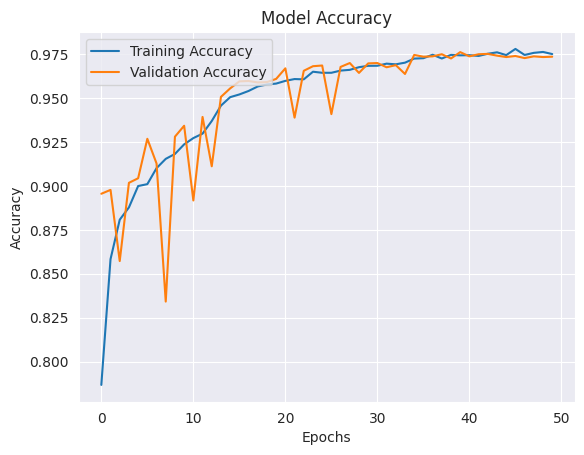

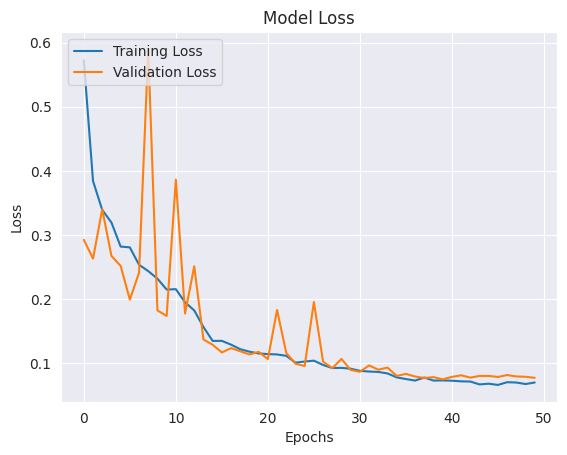

In [ ]:
# Evaluasi model dengan test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Visualisasi grafik training dan validation accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Visualisasi grafik training dan validation loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


4987/4987 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step


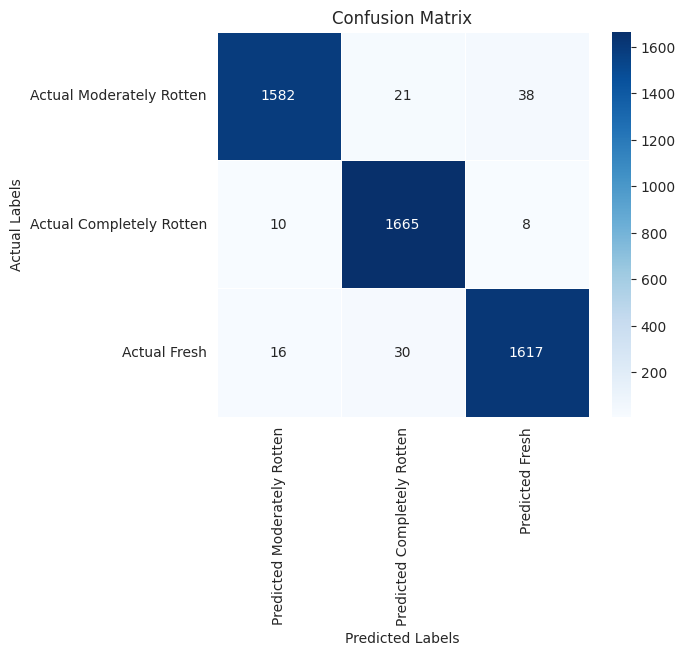


Classification Report:
                   precision    recall  f1-score   support

Moderately Rotten     0.9838    0.9640    0.9738      1641
Completely Rotten     0.9703    0.9893    0.9797      1683
            Fresh     0.9723    0.9723    0.9723      1663

         accuracy                         0.9753      4987
        macro avg     0.9755    0.9752    0.9753      4987
     weighted avg     0.9754    0.9753    0.9753      4987



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reset test generator sebelum melakukan prediksi
test_generator.reset()

# Lakukan prediksi pada test set
preds_1 = model.predict(test_generator, verbose=1)  # Set verbose=1 agar progres terlihat

# Konversi hasil prediksi ke label kelas (ambil indeks dengan probabilitas tertinggi)
predicted_labels = np.argmax(preds_1, axis=1)

# Buat Confusion Matrix
cm = confusion_matrix(test_generator.classes, predicted_labels)

# Konversi menjadi DataFrame untuk visualisasi
cm_df = pd.DataFrame(cm,
                     index=["Actual Moderately Rotten", "Actual Completely Rotten", "Actual Fresh"],
                     columns=["Predicted Moderately Rotten", "Predicted Completely Rotten", "Predicted Fresh"])

# Plot Heatmap Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

# Cetak Classification Report
print("\nClassification Report:")
print(classification_report(test_generator.classes, predicted_labels,
                            target_names=['Moderately Rotten', 'Completely Rotten', 'Fresh'], digits=4))


## Konversi Model

**Menyimpan Model dalam Format SavedModel**

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [ ]:
import shutil

# Kompres folder mymodel menjadi zip
shutil.make_archive('mymodel', 'zip', 'mymodel')
from google.colab import files

# Download zip file ke lokal
files.download('mymodel.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Simpan ke Format TensorFlow.js (TFJS)**

In [ ]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='output_1' \
    --saved_model_tags=serve \
    /content/mymodel/ \
    /content/modeltfjs/

2025-05-06 07:47:07.823838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746517627.856324   58602 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746517627.866135   58602 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-06 07:47:17.044526: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746517637.044768   58602 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
import shutil

# Buat file ZIP dari folder modeltfjs
shutil.make_archive('modeltfjs', 'zip', '/content/modeltfjs')


'/content/modeltfjs.zip'

In [ ]:
from google.colab import files

# Unduh file zip
files.download('modeltfjs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Simpan ke Format TensorFlow Lite (TF-Lite)**

In [ ]:
# Replace "SavedModel_path" with the actual path where your model was saved
# In this case, it's 'mymodel/' based on the previous code
converter = tf.lite.TFLiteConverter.from_saved_model("mymodel/")
tflite_model = converter.convert()

with tf.io.gfile.GFile('fruit_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Inference (Optional)

## Inference TF.LITE

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image

# 1. Load dan inisialisasi interpreter model TFLite
interpreter = tf.lite.Interpreter(model_path="model_converted.tflite")
interpreter.allocate_tensors()

# 2. Ambil detail input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)

# 3. Load gambar dan preprocessing
def load_and_preprocess_image(image_path, target_size):
    # Buka gambar dan ubah ukuran
    img = Image.open(image_path).resize(target_size)
    img = np.array(img).astype(np.float32)

    # Normalisasi jika diperlukan
    img = img / 255.0

    # Tambahkan batch dimension
    input_data = np.expand_dims(img, axis=0)
    return input_data

# Ganti dengan path gambar Anda
image_path = "test.jpeg"
input_data = load_and_preprocess_image(image_path, (150, 150))

# 4. Masukkan data ke model
interpreter.set_tensor(input_details[0]['index'], input_data)

# 5. Jalankan inferensi
try:
    interpreter.invoke()
except Exception as e:
    print("Error during inference:", e)
    exit()

# 6. Ambil output dan interpretasi hasil
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

# 7. Cetak hasil
print("Output Model:", output_data)
print("Kelas yang diprediksi:", predicted_class)


Input Details: [{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 150, 150,   3], dtype=int32), 'shape_signature': array([  1, 150, 150,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 44, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([1, 3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Model: [[0.7625104  0.19775388 0.03973574]]
Kelas yang diprediksi: 0


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load model yang sudah disimpan
model = tf.keras.models.load_model("/content/best_model.h5")

print("✅ Model berhasil dimuat dan siap untuk inferensi!")


✅ Model berhasil dimuat dan siap untuk inferensi!


In [ ]:
def predict_image(img_path, model):
    # Load gambar dan preprocess agar sesuai dengan input model
    img = image.load_img(img_path, target_size=(150, 150))  # Ubah ukuran target menjadi (150, 150)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
    img_array = img_array / 255.0  # Normalisasi jika model membutuhkan

    # Prediksi dengan model
    predictions = model.predict(img_array)

    # Ambil label dari label.txt
    with open("/content/label.txt", "r") as f:
        labels = [line.strip() for line in f.readlines()]

    # Tentukan label dengan probabilitas tertinggi
    predicted_class = labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100  # Persentase kepercayaan

    return predicted_class, confidence


In [ ]:
# Path gambar yang akan diuji
test_image_path = "/content/test.jpeg"  # Ubah sesuai dengan gambar uji yang ada

# Prediksi hasil
predicted_label, confidence = predict_image(test_image_path, model)

# Tampilkan hasil
print(f"🔍 Prediksi: {predicted_label} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
🔍 Prediksi: Completely rotten (67.50%)


In [ ]:
# Path gambar yang akan diuji
test_image_path = "/content/test_image_2.jpg"  # Ubah sesuai dengan gambar uji yang ada

# Prediksi hasil
predicted_label, confidence = predict_image(test_image_path, model)

# Tampilkan hasil
print(f"🔍 Prediksi: {predicted_label} ({confidence:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
🔍 Prediksi: Completely rotten (98.75%)


In [ ]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.2
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
commun